In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'baba' # ticker symbol
model_name = 'Random Forest Classifier' # for display later
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'amd': '03/17/1980'
               , 'baba': '09/15/2014'
               , 'crm': '06/23/2004'
               , 'goog': '08/16/2004'
               , 'idex': '05/23/2007'
               , 'iyw': '05/15/2000'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-14,260.855011,256.029999,260.320007,256.029999,18369900,256.029999,0.016480,0.018845,-0.032169,0.015882,-0.006010,1
2020-12-15,255.679993,252.300003,255.339996,255.110001,16595600,255.110001,0.000901,0.013397,-0.003593,0.014093,-0.008312,1
2020-12-16,263.179993,257.040009,257.739990,261.890015,15804800,261.890015,-0.016102,0.023887,0.026577,0.021000,-0.001275,-1
2020-12-17,264.850006,260.200012,264.700012,264.429993,14306600,264.429993,0.001020,0.017871,0.009699,0.021503,-0.000147,-1
2020-12-18,264.899994,259.200012,263.899994,260.000000,15981800,260.000000,0.014778,0.021991,-0.016753,0.022782,-0.003248,1
2020-12-21,260.459991,254.500000,255.169998,260.429993,10901800,260.429993,-0.020614,0.023418,0.001654,0.016085,0.003517,-1
2020-12-22,258.339996,255.410004,257.869995,255.830002,11468400,255.830002,0.007911,0.011472,-0.017663,0.018663,0.000703,1
2020-12-23,257.350006,252.529999,255.500000,256.179993,10729200,256.179993,-0.002661,0.019087,0.001368,0.012219,-0.004339,-1
2020-12-24,229.899994,211.229996,228.235001,222.000000,141830000,222.000000,0.027318,0.088387,-0.133422,0.056934,-0.032963,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
# va.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

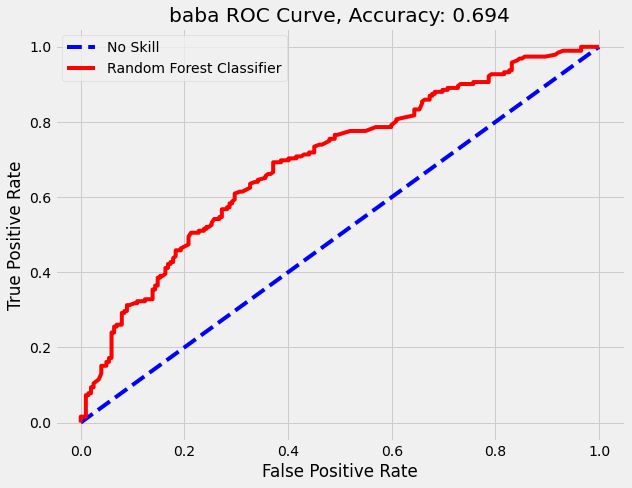

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

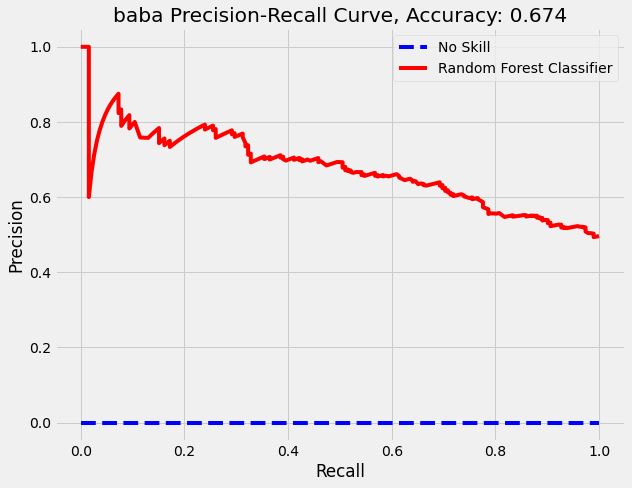

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

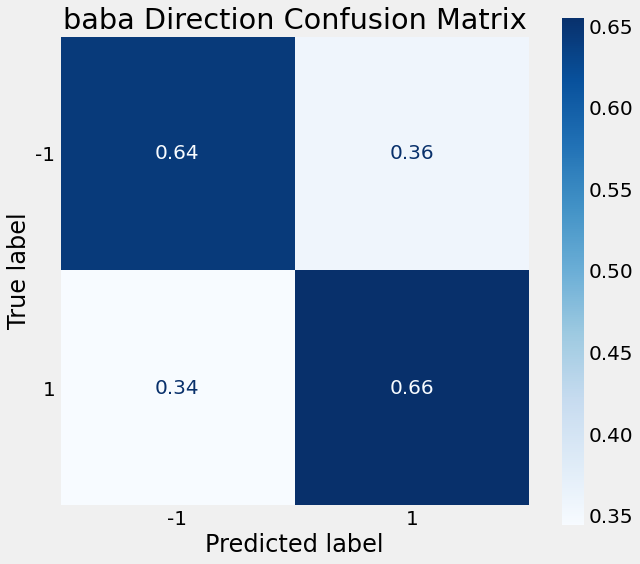

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6685714285714285'

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          2.249900e+02
Low           2.153200e+02
Open          2.168800e+02
Close         2.223600e+02
Volume        7.333250e+07
Adj Close     2.223600e+02
oc           -2.526741e-02
hl            4.490989e-02
adj           1.621624e-03
5stdev_adj    5.880387e-02
5sma_adj     -2.928827e-02
direction    -1.000000e+00
Name: 2020-12-28 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.025267
hl            0.044910
5stdev_adj    0.058804
5sma_adj     -0.029288
Name: 2020-12-28 00:00:00, dtype: float64

### Prediction...

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy baba


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-21,260.459991,254.500000,255.169998,260.429993,10901800,260.429993,-0.020614,0.023418,0.001654,0.016085,0.003517,-1,-1,0.017663
2020-12-22,258.339996,255.410004,257.869995,255.830002,11468400,255.830002,0.007911,0.011472,-0.017663,0.018663,0.000703,1,1,0.001368
2020-12-23,257.350006,252.529999,255.500000,256.179993,10729200,256.179993,-0.002661,0.019087,0.001368,0.012219,-0.004339,-1,1,-0.133422
2020-12-24,229.899994,211.229996,228.235001,222.000000,141830000,222.000000,0.027318,0.088387,-0.133422,0.056934,-0.032963,1,1,0.001622
2020-12-28,224.990005,215.320007,216.880005,222.360001,73332500,222.360001,-0.025267,0.044910,0.001622,0.058804,-0.029288,-1,1,0.000664


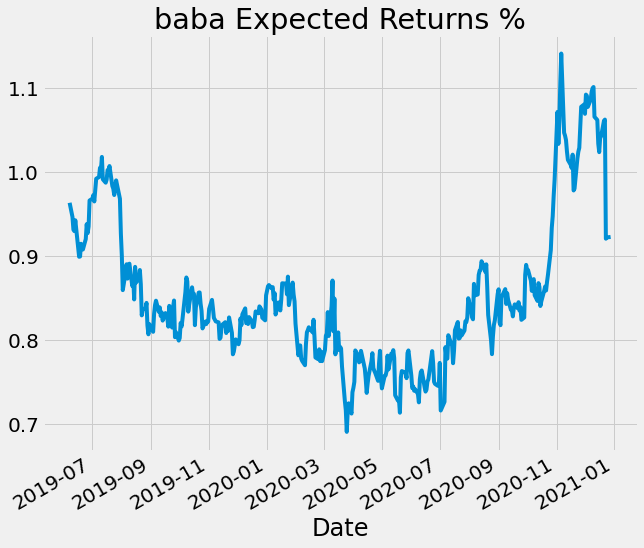

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

1.207026508040523

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

1.7526615990410273

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/